### Process Tiff Stack

In [8]:
import time
import numpy as np
from pvd_io import *
from pvd_par import PVD
from pvd_metrics import data_summary
from IPython.display import clear_output

### Single Stack

Starting pipeline.
Data loaded. Shape: (4, 92, 2044, 2042): 14.25 seconds
Data cropped. Shape: (4, 92, 2000, 2000): 4.23 seconds
Preprocessing complete: 102.51 seconds
Data skeletonized: 142.42 seconds
Number of tips per timepoint: [81, 77, 69, 73]
Number of knots per timepoint: [193, 183, 193, 196]
Outer segments found. Number of outer segments per timepoint: [53, 54, 51, 48]: 3.47 seconds
Matched 26 segments across all timepoints.
Segments matched. Number of matched segments per timepoint: [26, 26, 26, 26]: 0.22 seconds
Unmatched segments grouped: 4.10 seconds
All timepoints labeled successfully
Number of unique labels: 27
Processed data labeled: 21.44 seconds
Volume changes DataFrame generated: 24.05 seconds
Pipeline complete. Total time: 316.68 seconds
Saving data to drive...

Quality Score: 0.6208
Skeleton visualizations saved to pvd_analysis/DataSet00/exp240104_00_01_//visualizations
Outer segment visualizations saved to pvd_analysis/DataSet00/exp240104_00_01_//visualizations
Vol

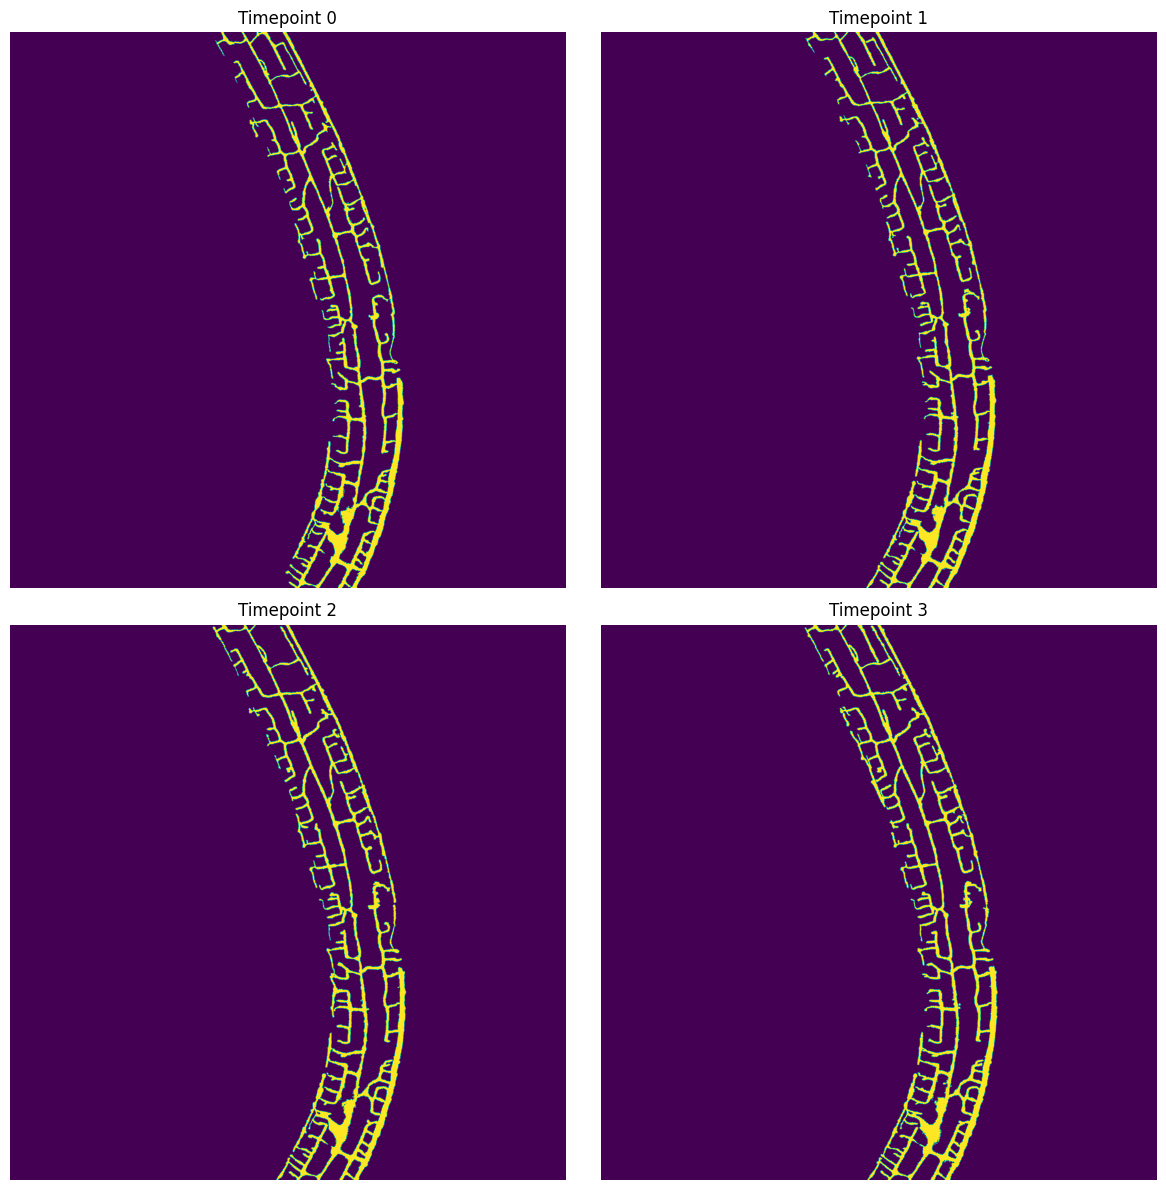

In [3]:
# Set path to zero-match file
data_path = 'S:/pvd_data'
results_path = 'pvd_analysis'
dataset = 'DataSet00'
session = 'exp240104_00_01_'
file = 'exp240104_00_01.tif'
tiff_stack_path = f"{data_path}/{dataset}/{session}_/{file}"
output_path = f"{results_path}/{dataset}/{session}/"

# Capture and display output
output_capture = OutputCapture()
sys.stdout = output_capture

try:
    pvd = PVD(data_path, dataset, session, file)
    pvd.run_pipeline()

    print(f"Saving data to drive...")
    pvd.save_results(output_path, save_tiff=False, save_numpy=False, save_plotly=True, save_labeled_tiff=False)

finally:
    sys.stdout = output_capture.original_stdout

# Save cell output
with open(f"{output_path}pipeline_log.txt", 'w') as f:
    f.write(str(output_capture.get_output()))

time.sleep(1)

In [6]:
len(pvd.matched_segments[1][0])

26

In [26]:
def calculate_similarity_matrices(pvd):
    num_segments = len(pvd.matched_segments[0])
    num_times = len(pvd.matched_segments)
    
    similarity_matrices = []
    
    for i in range(num_segments):
        segments = [pvd.matched_segments[t][i] for t in range(num_times)]
        
        similarity_mat = np.array([[len(seg1) - len(seg2) for seg2 in segments] for seg1 in segments])
        
        similarity_matrices.append(similarity_mat)
    
    return similarity_matrices

# Usage
similarity_matrices = calculate_similarity_matrices(pvd)

similarity_matrices = similarity_matrices[:-1]

similarity_matrices[0]

array([[  0, -11, -10, -12],
       [ 11,   0,   1,  -1],
       [ 10,  -1,   0,  -2],
       [ 12,   1,   2,   0]])

In [10]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

def fit_curve_and_calculate_length(points):
    # Convert list of tuples to numpy array
    points = np.array(points)
    
    # Separate x, y, z coordinates
    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    
    # Calculate the cumulative distance along the points
    dist = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    dist = np.insert(dist, 0, 0)  # Add starting point
    
    # Fit a cubic spline for each dimension
    cs_x = CubicSpline(dist, x)
    cs_y = CubicSpline(dist, y)
    cs_z = CubicSpline(dist, z)
    
    # Define the curve function
    def curve(t):
        return np.array([cs_x(t), cs_y(t), cs_z(t)])
    
    # Calculate the derivative of the curve
    def curve_derivative(t):
        return np.array([cs_x.derivative()(t), cs_y.derivative()(t), cs_z.derivative()(t)])
    
    # Function to calculate the length element
    def length_element(t):
        return np.linalg.norm(curve_derivative(t))
    
    # Calculate the total length of the curve
    length, _ = quad(length_element, dist[0], dist[-1])
    
    return curve, length

# Example usage
points = [(0, 0, 0), (1, 1, 1), (2, -1, 2), (3, 0, 1)]
fitted_curve, curve_length = fit_curve_and_calculate_length(pvd.matched_segments[1][0])

print(f"The length of the curve is approximately {curve_length:.4f}")

The length of the curve is approximately 30.8501


C:\Users\hssla\AppData\Local\Temp\ipykernel_6460\1668713829.py:34: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



In [20]:
seg_changes = []

for segment in similarity_matrices:
    for ii in range(segment.shape[0]-1):
        change = segment[ii+1, ii]
        seg_changes.append

In [38]:
import pandas as pd

seg_change_df = pd.DataFrame(seg_changes)
seg_change_df = seg_change_df.rename(columns={seg_change_df.columns[0]: 'changes'})
seg_change_df.head()

,changes
0,11
1,-1
2,2
3,4
4,-7


In [45]:
import plotly.express as px

fig = px.histogram(seg_change_df, x='changes', nbins=100)

fig.show()